# GDP Yearly Data Analysis

**Source**: Burea of Economic Analysis (used API)  
**Github Documentation**: https://github.com/us-bea/bea.R/tree/master  
**API Documentation**: https://apps.bea.gov/API/bea_web_service_api_user_guide.htm#tabs-4  
**BEA API Guide (Most Helpful)**: https://jwrchoi.com/post/how-to-use-bureau-of-economic-analysis-bea-api-in-r/  

# Loading Libraries

In [99]:
import pandas as pd
import censusdata
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format ='retina'

In [100]:
sharedFolder = '/work/group/egodat/reu23_clark/'
dataFolder = sharedFolder + 'data/'

In [101]:
gdp_data = pd.read_csv("GDP_Yearly_Data.csv")

In [102]:
gdp_data = gdp_data.rename(columns={"TimePeriod": "year", "DataValue": "gdp"})


In [103]:
gdp_data

,Code,GeoFips,GeoName,year,CL_UNIT,UNIT_MULT,gdp,NoteRef
0,CAGDP1-1,1001,"Autauga, AL",2013,Thousands of chained 2012 dollars,3,1477094.0,NaN
1,CAGDP1-1,1001,"Autauga, AL",2012,Thousands of chained 2012 dollars,3,1587254.0,NaN
2,CAGDP1-1,1001,"Autauga, AL",2021,Thousands of chained 2012 dollars,3,1502153.0,NaN
3,CAGDP1-1,1001,"Autauga, AL",2010,Thousands of chained 2012 dollars,3,1286603.0,NaN
4,CAGDP1-1,1001,"Autauga, AL",2014,Thousands of chained 2012 dollars,3,1478607.0,NaN
...,...,...,...,...,...,...,...,...
37411,CAGDP1-1,56045,"Weston, WY",2019,Thousands of chained 2012 dollars,3,318723.0,NaN
37412,CAGDP1-1,56045,"Weston, WY",2011,Thousands of chained 2012 dollars,3,290830.0,NaN
37413,CAGDP1-1,56045,"Weston, WY",2016,Thousands of chained 2012 dollars,3,305446.0,NaN
37414,CAGDP1-1,56045,"Weston, WY",2017,Thousands of chained 2012 dollars,3,303318.0,NaN


In [104]:
xwalk = pd.read_pickle(dataFolder + "/xwalk_data_combined.pkl")
xwalk

,ctyname,bgrp,cbsa
0,"Rockingham County, NH",330150710012,14460
1,"Merrimack County, NH",330130380002,18180
2,"Merrimack County, NH",330130415001,18180
3,"Hillsborough County, NH",330110225011,31700
4,"Hillsborough County, NH",330110103022,31700
...,...,...,...
57404,"Elko County, NV",320079515003,21220
57405,"Elko County, NV",320079515003,21220
57406,"Elko County, NV",320079517002,21220
57407,"Elko County, NV",320079502001,21220


In [105]:
#Extract block group code
xwalk['fips'] = (xwalk['bgrp'] / 10**7).astype(int)
fipsToCbsa = xwalk.groupby('fips').first()['cbsa']
fipsToCbsa = dict(zip(fipsToCbsa.index, fipsToCbsa.values)) #Dict is faster for lookup

In [106]:
gdp_data['CBSA'] = gdp_data['GeoFips'].apply(lambda c: fipsToCbsa.get(c, 99999))
gdp_data

,Code,GeoFips,GeoName,year,CL_UNIT,UNIT_MULT,gdp,NoteRef,CBSA
0,CAGDP1-1,1001,"Autauga, AL",2013,Thousands of chained 2012 dollars,3,1477094.0,NaN,33860
1,CAGDP1-1,1001,"Autauga, AL",2012,Thousands of chained 2012 dollars,3,1587254.0,NaN,33860
2,CAGDP1-1,1001,"Autauga, AL",2021,Thousands of chained 2012 dollars,3,1502153.0,NaN,33860
3,CAGDP1-1,1001,"Autauga, AL",2010,Thousands of chained 2012 dollars,3,1286603.0,NaN,33860
4,CAGDP1-1,1001,"Autauga, AL",2014,Thousands of chained 2012 dollars,3,1478607.0,NaN,33860
...,...,...,...,...,...,...,...,...,...
37411,CAGDP1-1,56045,"Weston, WY",2019,Thousands of chained 2012 dollars,3,318723.0,NaN,23940
37412,CAGDP1-1,56045,"Weston, WY",2011,Thousands of chained 2012 dollars,3,290830.0,NaN,23940
37413,CAGDP1-1,56045,"Weston, WY",2016,Thousands of chained 2012 dollars,3,305446.0,NaN,23940
37414,CAGDP1-1,56045,"Weston, WY",2017,Thousands of chained 2012 dollars,3,303318.0,NaN,23940


In [107]:
# variable_code: (readable_name, earliest_year, aggrigation_type)
aggType = {
    'GeoName': 'first',
    'CL_UNIT': 'first',
    'gdp': 'sum',
}

In [108]:
dataByCbsa = gdp_data.groupby(by=['CBSA', 'year']).agg(aggType).reset_index()

# Reading in GDF for Merging

In [109]:
gdf = pd.read_pickle(sharedFolder + 'gdf.pkl')
gdf

,CBSA,LSAD,POPESTIMATE2020,POPESTIMATE2021,POPESTIMATE2022,NAME,geometry,metro,micro,buff,inBuff,commuteBuffCount_19,workingPop_19,commutePercent_19,commuteBuffCount_20,workingPop_20,commutePercent_20,liminal
0,10180,Metropolitan Statistical Area,176866,177829,179308,"Abilene, TX","POLYGON ((-11148262.500 3832132.455, -11148249.363 3834995.870, -11148247.69...",False,False,"POLYGON ((-11309677.340 3783320.344, -11309649.123 3786484.756, -11309648.74...",True,7720.0,69422.0,11.120394,7146.0,66780.0,10.700809,False
1,10420,Metropolitan Statistical Area,701625,696225,697627,"Akron, OH","POLYGON ((-9060481.928 5063847.837, -9060475.582 5063847.837, -9059949.153 5...",False,False,"POLYGON ((-9254365.317 5020257.954, -9254364.768 5020601.075, -9254363.876 5...",True,90313.0,323548.0,27.913324,86722.0,306288.0,28.313875,False
2,10500,Metropolitan Statistical Area,148244,144922,145786,"Albany, GA","POLYGON ((-9400975.184 3713776.408, -9400980.639 3713776.539, -9400977.188 3...",False,False,"POLYGON ((-9578772.815 3741602.731, -9578761.883 3742545.444, -9578737.463 3...",True,4136.0,53083.0,7.791572,3686.0,50430.0,7.309141,False
3,10540,Metropolitan Statistical Area,128978,129948,130467,"Albany-Lebanon, OR","POLYGON ((-13720236.776 5551262.937, -13720393.181 5551342.918, -13720594.00...",False,False,"POLYGON ((-13880404.968 5518947.795, -13880524.300 5524862.300, -13880524.30...",True,6558.0,55731.0,11.767239,6390.0,54728.0,11.675925,False
4,10580,Metropolitan Statistical Area,899748,905369,904617,"Albany-Schenectady-Troy, NY","POLYGON ((-8247992.807 5305256.748, -8248085.647 5305790.638, -8248158.228 5...",False,False,"POLYGON ((-8472736.168 5278351.957, -8472566.135 5287189.715, -8472457.170 5...",True,25671.0,418341.0,6.136382,25289.0,390058.0,6.483395,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,49300,Micropolitan Statistical Area,116906,116129,116559,"Wooster, OH","POLYGON ((-9089178.853 5010653.858, -9088979.145 5010654.594, -9088976.584 5...",False,False,"POLYGON ((-9303427.427 5003041.204, -9303435.588 5003435.897, -9303478.778 5...",True,8894.0,50856.0,17.488595,8380.0,48312.0,17.345587,False
922,49380,Micropolitan Statistical Area,22207,22047,21947,"Worthington, MN","POLYGON ((-10627927.538 5441934.306, -10627791.171 5441933.071, -10627693.09...",False,True,"POLYGON ((-10853572.863 5404615.190, -10853573.241 5405092.161, -10853573.26...",False,0.0,10260.0,0.000000,0.0,9763.0,0.000000,False
923,49460,Micropolitan Statistical Area,23282,23334,23373,"Yankton, SD","POLYGON ((-10855702.126 5337734.746, -10853435.884 5337746.813, -10852392.82...",False,True,"POLYGON ((-11029881.460 5334892.015, -11029883.506 5335120.803, -11029889.85...",False,0.0,10934.0,0.000000,0.0,10222.0,0.000000,False
924,49780,Micropolitan Statistical Area,86450,86574,86113,"Zanesville, OH","POLYGON ((-9149881.580 4868949.855, -9149879.910 4868995.934, -9149875.012 4...",False,True,"POLYGON ((-9314594.513 4866712.033, -9313763.695 4878127.697, -9311212.035 4...",True,9978.0,34969.0,28.533844,10044.0,33194.0,30.258480,True


In [110]:
merge = pd.merge(gdf, dataByCbsa, on='CBSA', how='inner')
byYear = merge.groupby(by=['year', 'CBSA']).first()
byYear

LSAD  POPESTIMATE2020  POPESTIMATE2021  \
year CBSA                                                                     
2010 10100  Micropolitan Statistical Area            42204            42118   
     10140  Micropolitan Statistical Area            75855            76787   
     10180  Metropolitan Statistical Area           176866           177829   
     10220  Micropolitan Statistical Area            38087            38195   
     10300  Micropolitan Statistical Area            99320            99202   
...                                   ...              ...              ...   
2021 49660  Metropolitan Statistical Area           540211           537837   
     49700  Metropolitan Statistical Area           181458           182254   
     49740  Metropolitan Statistical Area           204528           206241   
     49780  Micropolitan Statistical Area            86450            86574   
     49820  Micropolitan Statistical Area            13874            13893   

            POPESTIMATE2022                               NAME  \
year CBSA                                                        
2010 10100            42037                       Aberdeen, SD   
     10140            77038                       Aberdeen, WA   
     10180           179308                        Abilene, TX   
     10220            38141                            Ada, OK   
     10300            98567                         Adrian, MI   
...                     ...                                ...   
2021 49660           535499  Youngstown-Warren-Boardman, OH-PA   
     49700           182813                      Yuba City, CA   
     49740           207842                           Yuma, AZ   
     49780            86113                     Zanesville, OH   
     49820            13849                         Zapata, TX   

                                                                                   geometry  \
year CBSA                                                                                     
2010 10100  POLYGON ((-10989736.448 5659978.604, -10990063.614 5659982.081, -10991045.78...   
     10140  POLYGON ((-13837615.681 5982098.516, -13837721.208 5982662.455, -13837981.24...   
     10180  POLYGON ((-11148262.500 3832132.455, -11148249.363 3834995.870, -11148247.69...   
     10220  POLYGON ((-10790478.575 4120536.368, -10790479.354 4120561.818, -10790477.24...   
     10300  POLYGON ((-9391131.716 5145826.837, -9391131.716 5145833.119, -9391133.164 5...   
...                                                                                     ...   
2021 49660  POLYGON ((-9017133.666 5032154.477, -9017136.678 5033818.858, -9017161.173 5...   
     49700  POLYGON ((-13539095.212 4764106.072, -13539054.023 4764201.441, -13539035.54...   
     49740  POLYGON ((-12775445.758 3848066.261, -12775405.127 3848156.952, -12775377.40...   
     49780  POLYGON ((-9149881.580 4868949.855, -9149879.910 4868995.934, -9149875.012 4...   
     49820  POLYGON ((-11063533.373 3121145.410, -11063672.411 3121226.482, -11063752.22...   

            metro  micro  \
year CBSA                  
2010 10100  False   True   
     10140  False   True   
     10180  False  False   
     10220  False   True   
     10300  False   True   
...           ...    ...   
2021 49660  False  False   
     49700  False  False   
     49740  False  False   
     49780  False   True   
     49820  False   True   

                                                                                       buff  \
year CBSA                                                                                     
2010 10100  POLYGON ((-11260422.376 5673350.686, -11260422.410 5673354.374, -11260428.59...   
     10140  POLYGON ((-14011312.614 6012982.039, -14012149.316 6021117.591, -14012178.10...   
     10180  POLYGON ((-11309677.340 3783320.344, -11309649.123 3786484.756, -11309648.74...   
     10220  POLYGON ((-10951414.331 4125460.111, -10951415.306 4125784.193

# Data Visualizations

In [111]:
years = range(2010, 2022, 1)

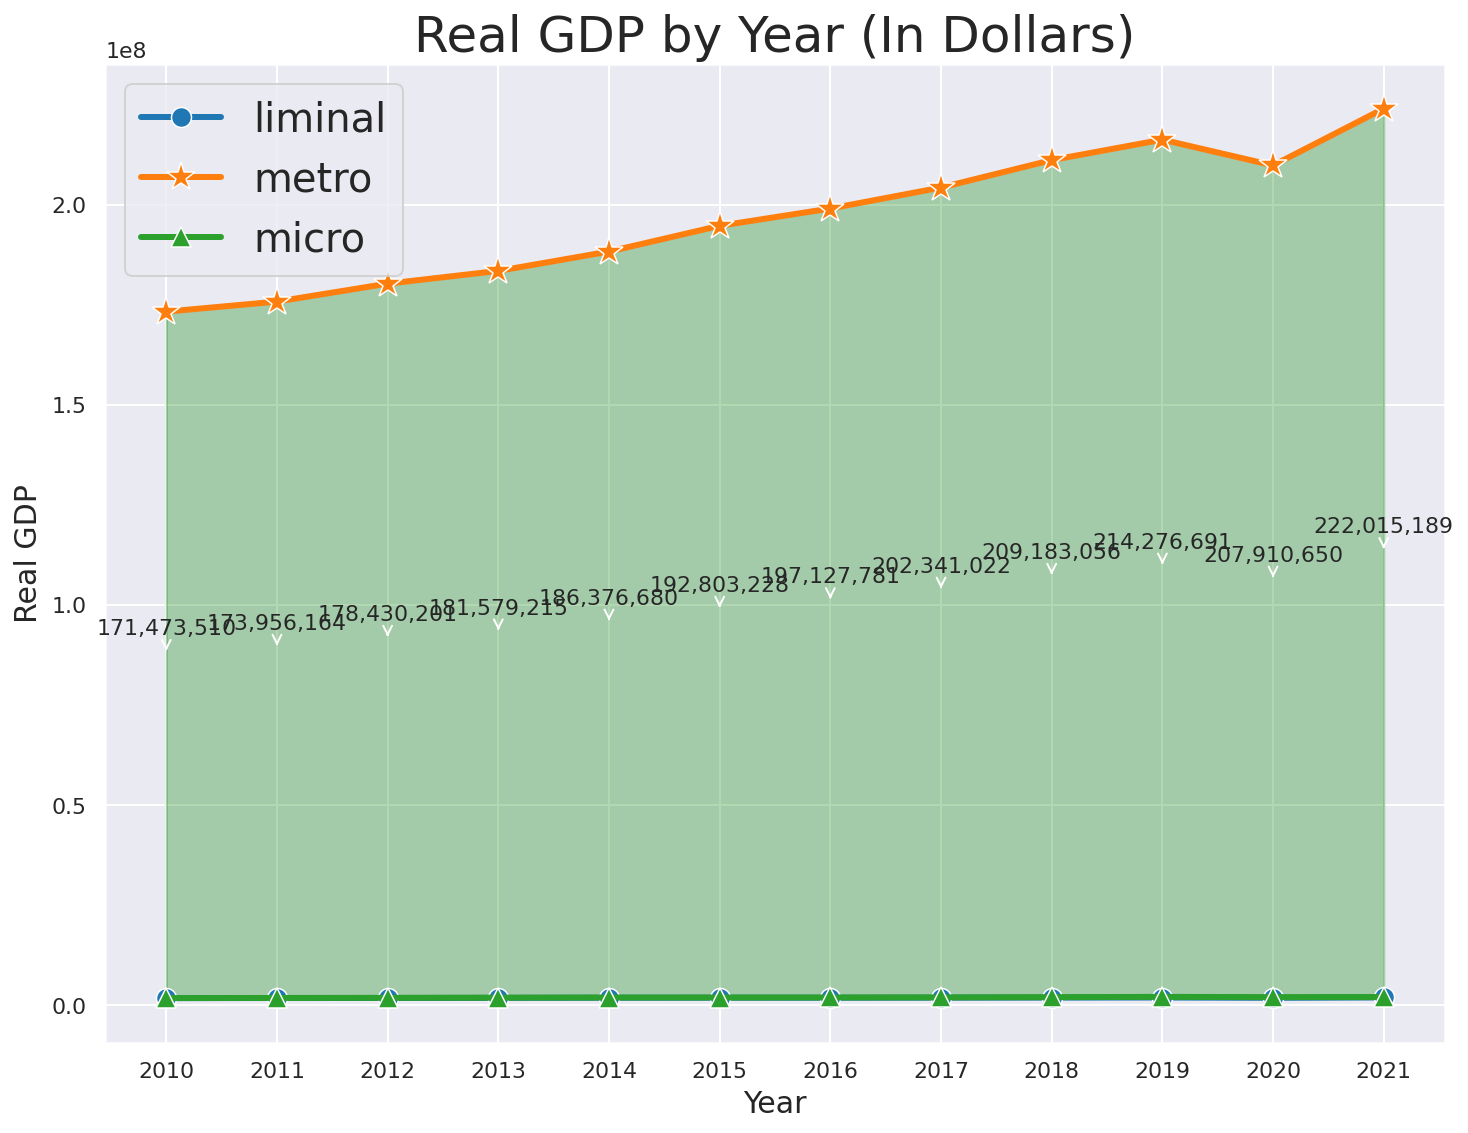

In [112]:
#Create empty lists to store x and y values for plotting
x_lim_values = []
y_lim_values = []

x_met_values = []
y_met_values = []

x_mic_values = []
y_mic_values = []

for year in years:
    median_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['gdp'].mean()
    if not pd.isna(median_val):
        x_lim_values.append(year)
        y_lim_values.append(median_val)

for year in years:
    median_val = merge[(merge['metro'] == True) & (merge['year'] == year)]['gdp'].mean()
    if not pd.isna(median_val):
        x_met_values.append(year)
        y_met_values.append(median_val)

for year in years:
    median_val = merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['gdp'].mean()
    if not pd.isna(median_val):
        x_mic_values.append(year)
        y_mic_values.append(median_val)

sns.set_style('darkgrid')
sns.set_context('notebook')

fig = plt.figure(figsize=(12, 9))

sns.lineplot(x=x_lim_values, y=y_lim_values, marker='o', label='liminal', linewidth = 3, markersize=10)
sns.lineplot(x=x_met_values, y=y_met_values, marker='*', label='metro', linewidth = 3, markersize=15)
sns.lineplot(x=x_mic_values, y=y_mic_values, marker='^', label='micro', linewidth = 3, markersize=10)

#area of difference between metro and liminal values
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) >= np.array(y_lim_values)), interpolate=True, alpha=0.3, color='green')
plt.fill_between(x_lim_values, y_met_values, y_lim_values, where=(np.array(y_met_values) < np.array(y_lim_values)), interpolate=True, alpha=0.3, color='red')

# Add labels for the difference between metro and liminal values with arrows
for i in range(len(x_lim_values)):
    diff = y_met_values[i] - y_lim_values[i]
    xy = (x_lim_values[i], (y_met_values[i] + y_lim_values[i]) / 2)
    xytext = (0, 8) if diff >= 0 else (0, -12)
    va = 'bottom' if diff >= 0 else 'top'
    ha = 'center'
    diff_str = f'{diff:,.0f}'
    plt.annotate(diff_str, xy=xy, xytext=xytext, textcoords='offset points', va=va, ha=ha, fontsize=11, arrowprops=dict(arrowstyle="->"))


plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Real GDP', fontsize=15)
plt.title('Real GDP by Year (In Dollars)', fontsize=25)
plt.grid(True)

# Set x-axis ticks to show all years
plt.xticks(x_lim_values)

plt.show()

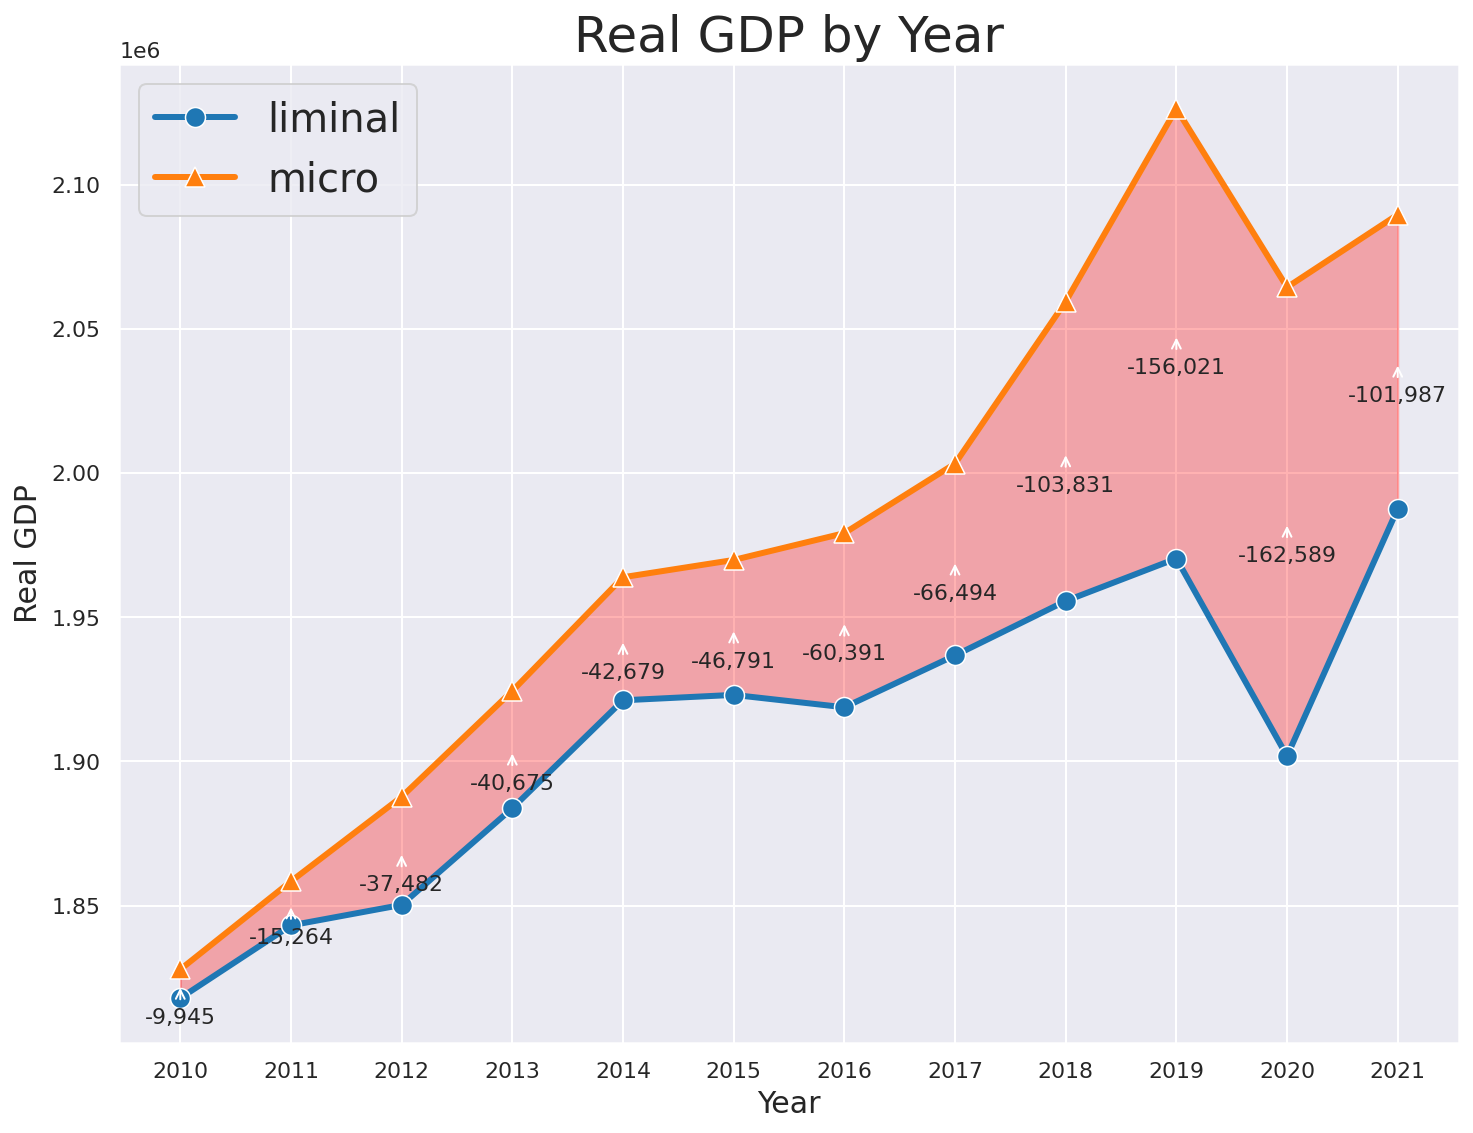

In [113]:
#Create empty lists to store x and y values for plotting
x_lim_values = []
y_lim_values = []

x_met_values = []
y_met_values = []

x_mic_values = []
y_mic_values = []

for year in years:
    median_val = merge[(merge['liminal'] == True) & (merge['year'] == year)]['gdp'].mean()
    if not pd.isna(median_val):
        x_lim_values.append(year)
        y_lim_values.append(median_val)

for year in years:
    median_val = merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['gdp'].mean()
    if not pd.isna(median_val):
        x_mic_values.append(year)
        y_mic_values.append(median_val)

sns.set_style('darkgrid')
sns.set_context('notebook')

fig = plt.figure(figsize=(12, 9))

sns.lineplot(x=x_lim_values, y=y_lim_values, marker='o', label='liminal', linewidth = 3, markersize=10)
sns.lineplot(x=x_mic_values, y=y_mic_values, marker='^', label='micro', linewidth = 3, markersize=10)

#area of difference between metro and liminal values
plt.fill_between(x_mic_values, y_lim_values, y_mic_values, where=(np.array(y_lim_values) >= np.array(y_mic_values)), interpolate=True, alpha=0.3, color='green')
plt.fill_between(x_mic_values, y_lim_values, y_mic_values, where=(np.array(y_lim_values) < np.array(y_mic_values)), interpolate=True, alpha=0.3, color='red')

# Add labels for the difference between metro and liminal values with arrows
for i in range(len(x_mic_values)):
    diff = y_lim_values[i] - y_mic_values[i]
    xy = (x_mic_values[i], (y_lim_values[i] + y_mic_values[i]) / 2)
    xytext = (0, 8) if diff >= 0 else (0, -12)
    va = 'bottom' if diff >= 0 else 'top'
    ha = 'center'
    diff_str = f'{diff:,.0f}'
    plt.annotate(diff_str, xy=xy, xytext=xytext, textcoords='offset points', va=va, ha=ha, fontsize=11, arrowprops=dict(arrowstyle="->"))


plt.legend(fontsize=20)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Real GDP', fontsize=15)
plt.title('Real GDP by Year', fontsize=25)
plt.grid(True)

# Set x-axis ticks to show all years
plt.xticks(x_lim_values)

plt.show()

In [114]:
for year in years:
    print(merge[(merge['liminal'] == True) & (merge['year'] == year)]['gdp'].mean())

1817910.2152777778
1843137.8159722222
1850236.1006944445
1883755.9027777778
1921190.21875
1923068.5069444445
1918768.1875
1936758.201388889
1955631.3541666667
1970365.8993055555
1901838.4097222222
1987641.0


In [115]:
for year in years:
    print(merge[(merge['micro'] == True) & (merge['liminal'] == False) & (merge['year'] == year)]['gdp'].mean())

1827854.7154471544
1858401.7642276422
1887717.605691057
1924430.7073170731
1963869.475609756
1969859.7601626017
1979159.081300813
2003252.2926829269
2059462.7113821139
2126387.2845528456
2064427.5894308942
2089628.4959349593
